#### http://parrt.cs.usfca.edu/doc/rf-importance/index.html
https://projecteuclid.org/euclid.ss/1009213726

http://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/

http://blog.datadive.net/selecting-good-features-part-i-univariate-selection/

http://scikit-learn.org/stable/modules/feature_selection.html

https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined

#### Code : https://github.com/parrt/random-forest-importances

### https://github.com/rhiever/sklearn-benchmarks

In [33]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.ensemble.forest import _generate_unsampled_indices
import warnings
from sklearn.metrics import r2_score

In [23]:
df = pd.read_csv('data/rent.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49352 entries, 0 to 49351
Data columns (total 6 columns):
bathrooms         49352 non-null float64
bedrooms          49352 non-null int64
price             49352 non-null int64
longitude         49352 non-null float64
latitude          49352 non-null float64
interest_level    49352 non-null int64
dtypes: float64(3), int64(3)
memory usage: 2.3 MB


In [118]:
df.columns
features = ['bathrooms', 'bedrooms', 'price', 'longitude', 'latitude']
dfr = df[features]
X_train,y_train = dfr.drop('price',axis=1),dfr['price']
X_train['random'] = np.random.random(size = len(X_train))
rf = RandomForestRegressor(n_estimators=100,min_samples_leaf=1,n_jobs=-1,oob_score=True)
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [119]:
rf.feature_importances_

array([0.02786145, 0.1042944 , 0.17900241, 0.54072218, 0.14811955])

In [120]:
X_train.columns

Index(['bathrooms', 'bedrooms', 'longitude', 'latitude', 'random'], dtype='object')

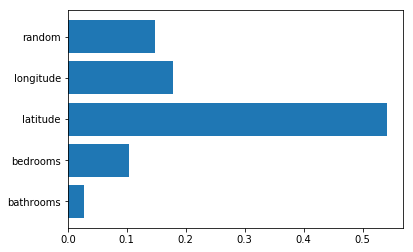

In [121]:
plt.barh(X_train.columns,rf.feature_importances_)
plt.show()

bathrooms  : -0.012868169774495453
bedrooms  : -0.2520069897895516
longitude  : -2.3867225143996555
latitude  : -1.5763588616820274
random  : -0.01767395021164453


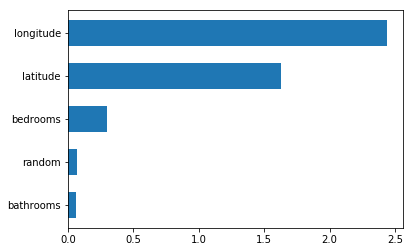

In [128]:
imp = permutation_importances(rf,X_train,y_train,oob_regression_r2_score)
I = pd.DataFrame(data={'Feature':X_train.columns, 'Importance':imp})
I = I.set_index('Feature')
I = I.sort_values('Importance', ascending=True)

plt.barh(np.arange(len(I.index)),I.Importance,height=.6, tick_label=I.index)
plt.show()

In [108]:
print(df.columns)
features = ['bathrooms', 'bedrooms', 'price', 'longitude', 'latitude','interest_level']
dfc = df[features]
X_train,y_train = dfc.drop('interest_level',axis=1),dfc['interest_level']
X_train['random'] = np.random.random(size = len(X_train))
rf = RandomForestClassifier(n_estimators=100,min_samples_leaf=5,n_jobs=-1,oob_score=True)
rf.fit(X_train,y_train)

Index(['bathrooms', 'bedrooms', 'price', 'longitude', 'latitude',
       'interest_level'],
      dtype='object')


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

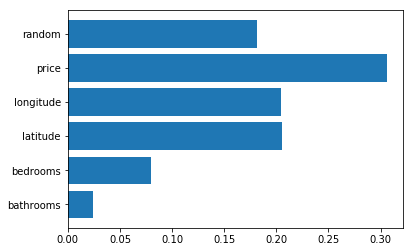

In [109]:
plt.barh(X_train.columns,rf.feature_importances_)
plt.show()

bathrooms  : 0.7085427135678392
bedrooms  : 0.6257497163235533
price  : 0.5877775976657481
longitude  : 0.6861120116712596
latitude  : 0.6906913600259361
random  : 0.7137502026260334


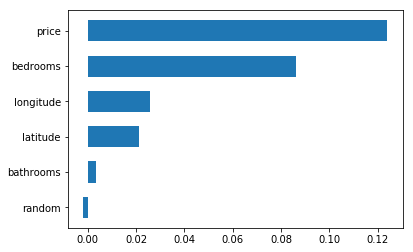

In [117]:
imp = permutation_importances(rf,X_train,y_train,oob_classifier_accuracy)

I = pd.DataFrame(data={'Feature':X_train.columns, 'Importance':imp})
I = I.set_index('Feature')
I = I.sort_values('Importance', ascending=True)

plt.barh(np.arange(len(I.index)),I.Importance,height=.6, tick_label=I.index)
plt.show()

In [98]:
def permutation_importances(rf,X_train,y_train,metric):
    baseline= metric(rf,X_train,y_train)
    X_train = X_train.copy(deep=False) # shallow copy
    imp=[]
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf,X_train,y_train)
        X_train[col ]= save
        imp.append(baseline - m)
        print(col," :", m)
    return np.array(imp)

def permutation_importances_raw(rf, X_train, y_train, metric):
    """
    Return array of importances from pre-fit rf; metric is function
    that measures accuracy or R^2 or similar. This function
    works for regressors and classifiers.
    """
    baseline = metric(rf, X_train, y_train)
    print(baseline)
    X_train = X_train.copy(deep=False) # shallow copy
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
        print(baseline - m)
    return np.array(imp)

In [111]:
def oob_classifier_accuracy(rf,X_train,y_train):
    X= X_train.values
    y = y_train.values
    n_samples = len(X)
    n_classes = len(np.unique(y))
    predictions = np.zeros((n_samples,n_classes))
    for tree in rf.estimators_:
        unsampled_indices = _generate_unsampled_indices(tree.random_state,n_samples)
        tree_preds = tree.predict_proba(X[unsampled_indices,:])
        predictions[unsampled_indices] += tree_preds
    predicted_class_indices = np.argmax(predictions,axis=1)
    predict_classes = [rf.classes_[i] for i in predicted_class_indices]
    oob_score = np.mean(predict_classes == y)
    return oob_score
    
    

In [42]:
def oob_regression_r2_score(rf,X_train,y_train):
    X = X_train.values
    y = y_train.values
    
    n_samples = len(X)
    predictions = np.zeros(n_samples)
    n_predictions = np.zeros(n_samples)
    for tree in rf.estimators_:
        unsampled_indices = _generate_unsampled_indices(tree.random_state,n_samples)
        tree_preds = tree.predict(X[unsampled_indices,:])
        predictions[unsampled_indices] += tree_preds
        n_predictions[unsampled_indices] +=1
        
    if(n_predictions == 0).any():
        warnings.warn("Too few trees; some variables do not have OOB scores. ")
        n_predictions[n_predictions==0]=1
    predictions /= n_predictions
    oob_score = r2_score(y, predictions)
    return oob_score